<a href="https://colab.research.google.com/github/gcosma/DeepLearningTutorials/blob/master/SimpleSequentialModelmMHealth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

              **Click on the OPEN IN COLAB icon above**

**Tutorial: HOW TO Create a Deep Sequential Model in Keras for mHealth data classification in 5 Steps** 

by Dr Georgina Cosma

Learning outcomes:
* Load Data.
* Apply z-score data normalisation
* Get the frequency of each class 
* Visualise the class labels
* Define a Sequential model for detecting human activity in multi-sensor data
* Compile the Sequential Model
* Train and Test a mode using k-fold cross validation.  


**Not using Colab?** If you are not using Colab you will need to Setup a Python Environment for 
Machine Learning and Deep Learning with Anaconda. You must have Python 2 or 3 
installed and configured. You must install SciPy (including NumPy) and the relevant
libraries including Keras. 

**Using Colab:** Some difficulties may be
experienced with mounting, but the code and explanation here will help you overcome these. 

I have included the datasets  in the GitHub repository and you can also download the data from: https://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset

**About the mHealth multi-sensor dataset:** The mHealth (Mobile Health) dataset is a benchmark dataset for human behaviour analysis based on multi-modal body sensing. The mHealth dataset comprises body motion and vital signs recordings for ten volunteers of diverse profile while performing 12 physical activities: Standing still (1 min), Sitting and relaxing (1 min), Lying down (1 min), Walking (1 min), Climbing stairs (1 min), Waist bends forward (20x), Frontal elevation of arms (20x), Knees bending (crouching) (20x), Cycling (1 min), Jogging (1 min), Running (1 min), and Jump front & back (20x). Sensors on each subject's chest, right wrist and left ankle were used to measure the motion experienced by diverse body parts, namely, acceleration, rate of turn and magnetic field orientation. All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity. This dataset has been found to generalize to common activities of the daily living, due to the diversity of body parts involved in each activity (e.g., frontal elevation of arms vs. knees bending), the intensity of the actions (e.g., cycling vs. sitting and relaxing) and their execution speed or dynamicity (e.g., running vs. standing still). For more information see: https://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset




**Step 1: Import libraries** 

In [0]:
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Activation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from scipy import stats
#Below several optimisers are imported. This tutorial is using the Adam optimiser
#but you can easily replace Adam with another optimiser from the list. 
from keras.optimizers import SGD, Adam, Adadelta, RMSprop, Adagrad, Adamax, Nadam

**Step 2: Mount to Google Drive in order to access your data file**

In [14]:
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive/Colab Notebooks"

#if you need to remount
#drive.mount("/content/drive", force_remount=True)

#If you want to unmount and reset then: 
#Step 1: From the menu select Runtime--->Reset all Runtimes... 
#Step 2: Runtime--->Run all or you can run each Cell at a time. There will be a message 
# "Go to a URL in a browser" and you must click on that and copy and paste the authorisation code 
# from the page into the authorisation code text box.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 3: Choose your dataset.**

In [15]:
#All datasets are available in Github. I added the datasets into a data folder where all data are kept separate from the code. 
# To load the dataset you must uncomment the dataset you want to load. One dataset contains the data of a single person. 
#dataset1 = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/MHEALTHDATASET/mHealth_subject1txt.csv", delimiter=",")
#dataset1 = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/MHEALTHDATASET/mHealth_subject2txt.csv", delimiter=",")
#dataset1 = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/MHEALTHDATASET/mHealth_subject3txt.csv", delimiter=",")
#dataset1 = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/MHEALTHDATASET/mHealth_subject4txt.csv", delimiter=",")
#dataset1 = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/MHEALTHDATASET/mHealth_subject5txt.csv", delimiter=",")
#dataset1 = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/MHEALTHDATASET/mHealth_subject6txt.csv", delimiter=",")
#dataset1 = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/MHEALTHDATASET/mHealth_subject7txt.csv", delimiter=",")
#dataset1 = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/MHEALTHDATASET/mHealth_subject8txt.csv", delimiter=",")
#dataset1 = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/MHEALTHDATASET/mHealth_subject9txt.csv", delimiter=",")
dataset1 = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/MHEALTHDATASET/mHealth_subject10txt.csv", delimiter=",")
print(dataset1)

[[ -9.5767   -1.4661   -0.34247 ...   0.89477  -0.72002   0.     ]
 [ -9.5928   -1.17     -0.67372 ...   0.89837  -0.35904   0.     ]
 [ -9.884    -1.2555   -0.49195 ...   0.71692  -0.35726   0.     ]
 ...
 [ -9.4842   -3.0643   -1.0337  ...  16.17     43.262     0.     ]
 [ -8.7889   -2.4757   -0.61229 ...   1.8494   43.373     0.     ]
 [ -8.6851   -1.0985    0.15377 ... -15.833    35.976     0.     ]]


**Step 4:**
Dataset comprises of 23 inputs, and a vector of categorical target values (0-12). Each target value corresponds to one of 12 physical activities as explained in the first part of this tutorial. 

In [16]:
#Input data and labels need to be separated before training the model.
X = dataset1[:,0:23]        
labels= dataset1[:,23];

#Here zscore is applied to normalise the values of each column. 
# Z-scores are linearly transformed data values having a mean of zero and a standard deviation of 1. 
X=stats.zscore(X)

#Convert the single vector of 13 classes to a matrix of 1s and 0s. 
#This is called one-hot-encoding. With one-hot encoding the integer encoded variable is removed and a new binary 
# variable is added for each unique integer value. For a quick explanation see: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
Yenc = to_categorical(labels) 
print(Yenc)

#Check the size of matrix Yenc. The number of rows should be equal to the number of classes classes.
#In this example classes start from 0 to 12. Therefore we have 13 classes. 
Yenc.shape

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


(135168, 13)

**Count the frequency of each class. The datasets are considered as Limited Training Datasets making this classification task a challenging one. The reason the datasets are considered to be limited is because the cases in the null class range from 65.73\%-78.19\%, whereas the cases in the remaining 12 classes range from 0.67\%-3.13\%. Hence, the number of cases in all classes 0-12 are comparatively lower than the 0 class, and the number of training samples are limited.**

In [17]:
#Count the number of cases in each class. 
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


{0.0: 100814,
 1.0: 3072,
 2.0: 3072,
 3.0: 3072,
 4.0: 3072,
 5.0: 3072,
 6.0: 2867,
 7.0: 2867,
 8.0: 2969,
 9.0: 3072,
 10.0: 3072,
 11.0: 3072,
 12.0: 1075}

**Plot a histogram of the labels**

Text(0.5, 1.0, "Histogram with 'auto' bins")

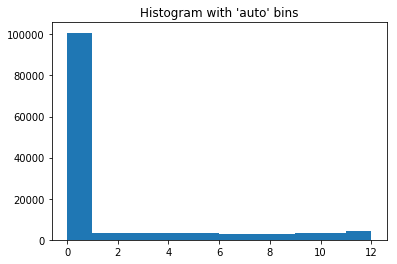

In [18]:
plt.hist(labels, bins=np.arange(labels.min(), labels.max()+1))
plt.title("Histogram with 'auto' bins")

**Step 5: Create the Sequential model**
A Sequential model is a linear stack of layers.
Code for the k-fold cross validation was adapted from https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

fit(X,Y) is for training the model with the given inputs X (and corresponding training labels Y). Adjust the number of epochs to avoid overtraining your network.

evaluate(X,Y) is for evaluating the already trained model using the test data. Returns the accuracy values for each k-fold using the test data. **



In [23]:
# Define k-fold cross validation test. In this application k=10.
# 10-fold allows us to partition the data into k different training and testing datasets. 
# k-fold, when applied to large datasets, can result in slow training, but it is a suitable 
# validation approach when the datasets are limited (see step 4 for an explanation of what is meant by 'limited'). 
# k-fold results to thorough evaluations of the model.  
# For a nice introduction to k-fold cross validation see: https://machinelearningmastery.com/k-fold-cross-validation/
kfold = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
cvscores = []
#get number of columns in training data
n_cols = X.shape[1]
#Split the dataset into folds of train and test data.
for train, test in kfold.split(X, labels):
  model = Sequential()
  # Dense(256) is a fully-connected layer with 256 hidden units.
  # in the first layer, you must specify the expected input data shape:
  # here, n_cols=23-dimensional vectors. n_cols = X.shape[1] gave 
  # the number of columns in the data. 
  # For more information on the options for constructing a Sequential model see
  # https://keras.io/getting-started/sequential-model-guide/ 
  model.add(Dense(256, activation='relu', input_shape=(n_cols,)))
  model.add(Activation('relu'))
  #model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256,activation='relu'))
  #13 refers to the number of classes. SOFTMAX is used for multi-classification.
  model.add(Dense(13, activation='softmax'))

  #####################################################################################
  #Setup the optimisers - you can try out several one at a time 
  # simply relace optimizer='adam' when you compile the model. 
  sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
  adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  adadelt=Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
  rmsprop=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
  adagrad=Adagrad(lr=0.01, epsilon=None, decay=0.0)
  adamax=Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  nadam=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
  #####################################################################################

  ############### Now you can change the name of the optimiser if you wish. 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  ############# Fit the model (training)
  model.fit(X[train], Yenc[train], epochs=20, batch_size=50, verbose=0)

  ###################### Test the model using the test data
  score = model.evaluate(X[test], Yenc[test], batch_size=50, verbose=0)
  print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  #Displays the accuracy of each fold when applied to the test data.
  cvscores.append(score[1] * 100)
  #Indentation is important here. Show the mean accuracy and standard deviation over all k-folds
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


acc: 95.41%

acc: 57.17%

acc: 65.66%

acc: 83.61%

acc: 81.53%

acc: 89.38%

acc: 93.69%

acc: 96.92%

acc: 96.54%

acc: 76.78%
83.67% (+/- 13.00%)


In [20]:
# Print the structure of the Sequential model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 256)               6144      
_________________________________________________________________
activation_39 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_40 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_80 (Dense)             (None, 13)                3341      
Total para

**Extra code. How to install the GraphViz Library  http://www.graphviz.org/
The image is stored in your drive.**



In [0]:
!pip install -q pydot
from keras.utils.vis_utils import plot_model
#Prints the model to a file in the directory
plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/model_plot3.png', show_shapes=True, show_layer_names=True)

**Extra code. How to decode a one-hot-encoded matrix**

In [22]:
#Decode from one-hot-encoded matrix
res= [np.where(r==1)[0][0] for r in Yenc]
print(res)
max(res)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

12